In [20]:
%matplotlib inline

import pandas
import numpy
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics, model_selection, preprocessing, pipeline

# ML methods
from sklearn.ensemble import RandomForestClassifier

In [25]:
test_csv = pandas.read_csv('./test.csv')
train_csv = pandas.read_csv('./train.csv')
raw = pandas.concat([test_csv, train_csv])
raw[:2]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272


In [26]:
raw.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [27]:
raw.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

## TODO
* Impute missing age values
* Deal with missing cabin info?


In [119]:
data = pandas.DataFrame({
    'sex': raw['Sex'].astype('category'),
    'age': raw['Age'],
    'survived': raw['Survived'],
})
data.index=raw['PassengerId']
data = pandas.get_dummies(data, columns=None, drop_first=True)
data[:2]

,age,survived,sex_male
PassengerId,,,
892,34.5,NaN,1
893,47.0,NaN,0


In [120]:
without_result = data['survived'].isnull()
has_result = ~without_result
target_columns = ['survived']
data_columns = list(set(data.columns) - set(target_columns))

test_size = 0.4
seed = 1
s = model_selection.train_test_split(data[has_result][data_columns], data[has_result][target_columns], test_size=test_size, random_state=seed)
X_train, X_test, Y_train, Y_test = s
Y_train = Y_train['survived']
Y_test = Y_test['survived']

# Model

In [80]:
estimator = pipeline.make_pipeline(
    preprocessing.Imputer(strategy='mean'),
    RandomForestClassifier(),
)
parameters = {
    'randomforestclassifier__n_estimators': [ 1, 4, 16, 32, 64, ],
    'randomforestclassifier__min_samples_split': [ 0.1, 0.05, 0.01, 0.005, ],
}
search = model_selection.GridSearchCV(estimator, parameters, cv=7)
search.fit(X_train, Y_train)

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decr...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [1, 4, 16, 32, 64], 'randomforestclassifier__min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [81]:
search

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decr...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [1, 4, 16, 32, 64], 'randomforestclassifier__min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [89]:
# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=numpy.linspace(.1, 1.0, 5)):
    np = numpy
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    s = model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = s
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/lib/python3.6/site-packages/matplotlib/pyplot.py'>

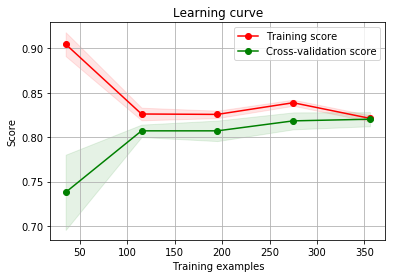

In [88]:
plot_learning_curve(search.best_estimator_, 'Learning curve', X_train, Y_train)

In [96]:
Y_pred = search.best_estimator_.predict(X_test)
metrics.accuracy_score(Y_pred, Y_test)

0.7535014005602241

In [129]:
def make_submission(estimator):
    without_result = data['survived'].isnull()
    d = data[without_result][data_columns]
    
    s = pandas.DataFrame({
        'PassengerId': d.index,
        'Survived': estimator.predict(d).astype('int'),
    })
    s.to_csv('submission.csv', index=False)
    return s
    
make_submission(search.best_estimator_)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
